# RDS Homework 2 Problem 3 Template
## Spring 2024


In [1]:
!pip install shap

In [2]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

from sklearn.metrics import confusion_matrix

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [3]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [4]:
# create X and y
X_train = newsgroups_train.data
y_train = newsgroups_train.target
X_test = newsgroups_test.data
y_test = newsgroups_test.target

In [5]:
# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [6]:
# Train & fit the classifier
clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
clf.fit(X_train_transformed, y_train)

SGDClassifier(loss='log_loss')

### Part (B)

In [7]:
# Confusion Matrix
y_pred = clf.predict(X_test_transformed)
confusion_matrix(y_test, y_pred)

array([[276,  43],
       [  4, 394]])

#### Explainer

In [8]:
# Initialize the explainer and apply to test data
explainer = shap.LinearExplainer(clf, X_train_transformed, feature_perturbation="interventional")
# explains how each feature in each sample in X_test_transformed affects the final prediction for the given sample
shap_values = explainer.shap_values(X_test_transformed)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [9]:
# Select 5 documents in the test set for explanation
np.random.seed(42)
selected_indices = np.random.choice(range(len(X_test)), size=5, replace=False)
print(selected_indices)

[120 331  39 636 514]


In [10]:
# Visually explain 5 documents selected from the test set
X_test_array = X_test_transformed.toarray()
# have to call shap.force_plot() individually (not in a loop)
  # otherwise Jupyter Notebook won't display the images

In [11]:
i=120
shap.initjs()
print("Positive" if y_test[i] else "Negative", "Review:")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=vectorizer.get_feature_names_out()
)

Positive Review:


In [12]:
i=331
shap.initjs()
print("Positive" if y_test[i] else "Negative", "Review:")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=vectorizer.get_feature_names_out()
)

Negative Review:


In [13]:
i=39
shap.initjs()
print("Positive" if y_test[i] else "Negative", "Review:")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=vectorizer.get_feature_names_out()
)

Positive Review:


In [14]:
i=636
shap.initjs()
print("Positive" if y_test[i] else "Negative", "Review:")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=vectorizer.get_feature_names_out()
)

Positive Review:


In [15]:
i=514
shap.initjs()
print("Positive" if y_test[i] else "Negative", "Review:")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=vectorizer.get_feature_names_out()
)

Negative Review:


### Part (C)


#### Part (i)

In [16]:
# Compute the accuracy of the classifier and the number of misclassified documents
accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
misclassified_indices = np.where(y_test != y_pred)[0]
num_misclassified = len(misclassified_indices)
print("Accuracy of classifier:", accuracy)
print("Number of misclassified documents:", num_misclassified)

Accuracy of classifier: 0.9344490934449093
Number of misclassified documents: 47


#### Part (ii)

In [17]:
# Calculate conf_i for all misclassified documents
# probability of each class for all instances in X_test
y_prob = clf.predict_proba(X_test_transformed)
conf_i = np.abs(y_prob[misclassified_indices, 0] - y_prob[misclassified_indices, 1])

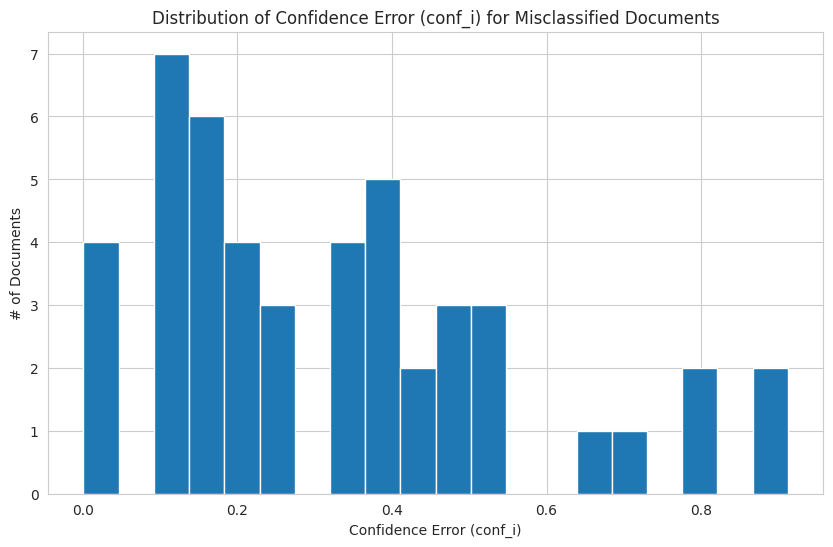

In [18]:
# Plot conf_i
plt.figure(figsize=(10, 6))
plt.hist(conf_i, bins=20)
plt.title('Distribution of Confidence Error (conf_i) for Misclassified Documents')
plt.xlabel('Confidence Error (conf_i)')
plt.ylabel('# of Documents')
plt.show()

#### Part (iii)

In [19]:
# Identify tokens (word_j) that contributed to the misclassification of documents
# Compute the number of documents (count_j) these words helped to misclassify
# Compute the sum of absolute SHAP values (weight_j) for each word_j

# contains all words which contributed to the misclassiication of documents
count_j = {}
  # word_j : count_j
weight_j = {}
  # word_j : weight_j

# iterate thru misclassified documents
for i in misclassified_indices:
  # value of each feature's affect on final prediction for doc_i
  vals = shap_values[i, :]
  # all features
  feats = vectorizer.get_feature_names_out()
  y_pred_i = y_pred[i]
  for feat_i, val_i in zip(feats, vals):
    word_j = feat_i
    if (y_pred_i == 0 and val_i < 0) or (y_pred_i == 1 and val_i > 0):
      # this feature contributed to misclassification of doc_i
      if word_j not in count_j:
        count_j[word_j] = 1
        weight_j[word_j] = np.abs(val_i)
      else:
        count_j[word_j] += 1
        weight_j[word_j] += np.abs(val_i)

In [20]:
# Compute the number of documents (count_j) these words helped to misclassify

In [21]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j

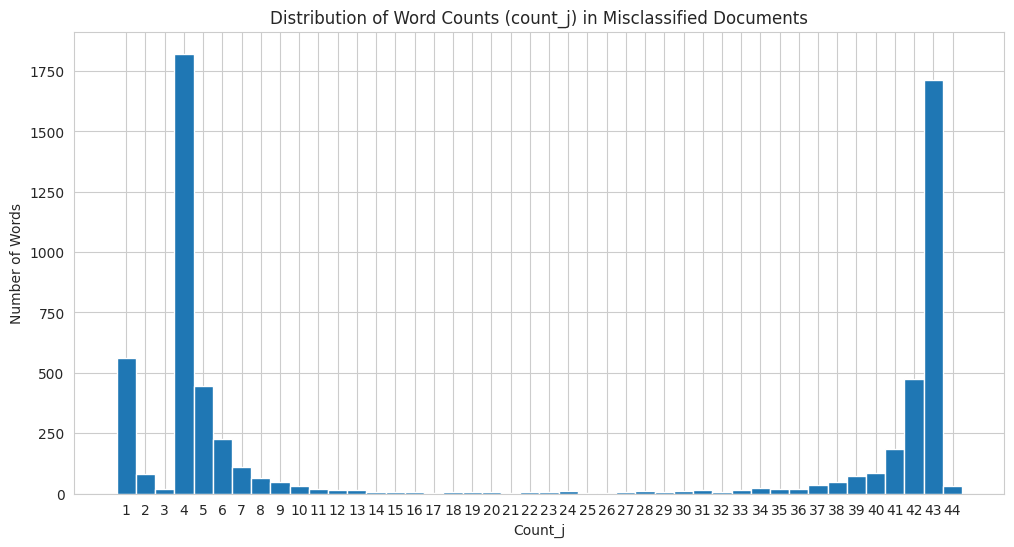

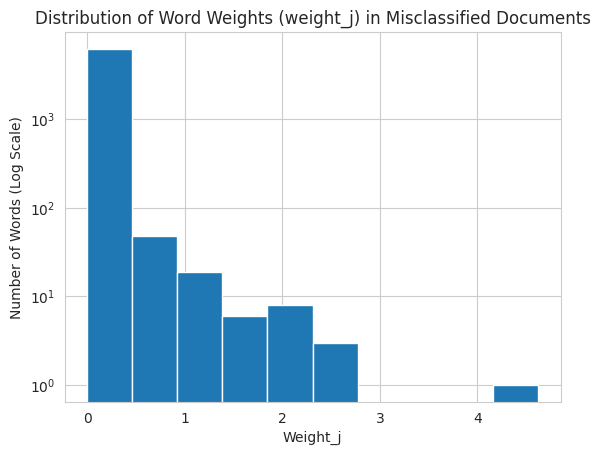

In [22]:
# Plot the distribution of count_j and weight_j
plt.figure(figsize=(12, 6))
counts_j = list(count_j.values())
bin_edges = np.arange(min(counts_j) - 0.5, max(counts_j) + 1.5, 1)
plt.hist(counts_j, bins=bin_edges)
plt.title('Distribution of Word Counts (count_j) in Misclassified Documents')
plt.xlabel('Count_j')
plt.ylabel('Number of Words')
plt.xticks(range(min(counts_j), max(counts_j) + 1))
plt.show()

weights_j = list(weight_j.values())
# plt.figure(figsize=(10, 6))
plt.hist(weights_j, log=True)
plt.title('Distribution of Word Weights (weight_j) in Misclassified Documents')
plt.xlabel('Weight_j')
plt.ylabel('Number of Words (Log Scale)')
plt.show()

### Part (D)

In [23]:
old_y_pred = y_pred

In [24]:
# Implement a strategy for feature selection
# sum all the shap values for each feature
feature_importance = np.sum(np.abs(shap_values), axis=0)
threshold = np.percentile(feature_importance, 75)
# remove bottom 75% least important features
selected_features = np.where(feature_importance >= threshold)[0]
X_train_selected = X_train_transformed[:, selected_features]
X_test_selected = X_test_transformed[:, selected_features]
clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)

In [25]:
# Identify at least  one example that was misclassified before feature selection and that is classified correctly after feature selection
accuracy_post = sklearn.metrics.accuracy_score(y_pred, y_test)
misclassified_indices_post = np.where(y_test != y_pred)[0]
num_misclassified_post = len(misclassified_indices_post)
print("Accuracy of classifier before:", accuracy)
print("Accuracy of classifier after:", accuracy_post)
print("Number of misclassified documents before:", num_misclassified)
print("Number of misclassified documents after:", num_misclassified_post)
print("Indices of misclassified documents before:", misclassified_indices)
print("Indices of misclassified documents after:", misclassified_indices_post)

Accuracy of classifier before: 0.9344490934449093
Accuracy of classifier after: 0.9358437935843794
Number of misclassified documents before: 47
Number of misclassified documents after: 46
Indices of misclassified documents before: [ 20  38  54  62  94  99 107 109 123 126 134 156 197 216 217 245 271 335
 366 377 399 406 413 419 438 447 461 469 473 558 568 591 605 607 610 615
 620 623 641 658 668 677 679 683 685 694 703]
Indices of misclassified documents after: [ 25  38  54  62  94  99 107 109 121 123 126 134 156 197 216 217 245 271
 335 366 377 399 406 413 438 447 461 469 558 568 591 605 607 610 615 620
 623 641 658 668 677 679 683 685 694 703]


In [26]:
i=20
shap.initjs()
print("Positively" if old_y_pred[i] else "Negatively", "Predicted Review", i, "(Before Feature Selection):")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=vectorizer.get_feature_names_out()
)

Positively Predicted Review 20 (Before Feature Selection):


In [27]:
explainer = shap.LinearExplainer(clf, X_train_selected, feature_perturbation="interventional")
# explains how each feature in each sample in X_test_transformed affects the final prediction for the given sample
shap_values = explainer.shap_values(X_test_selected)
X_test_array = X_test_selected.toarray()
selected_feature_names = vectorizer.get_feature_names_out()[selected_features]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [28]:
i=20
shap.initjs()
print("Positively" if y_pred[i] else "Negatively", "Predicted Review", i, "(After Feature Selection):")
shap.force_plot(
    explainer.expected_value, shap_values[i,:], X_test_array[i,:],
    feature_names=selected_feature_names
)

Negatively Predicted Review 20 (After Feature Selection):
